
![delensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - masked sky
In this notebook you perfrom QE and iterative lensing reconstruction for a single simulation, and for a masked sky.
The simulations are created upon runtime inclusive of isotropic white noise and without foregrounds, using a built-in CMB-simulations module.

We generate a simple mask leaving us with a sky fraction of about $33$ percent.
Masked data for iterative lensing reconstruction results in a large, so called mean-field, and biases the lensing potential estimate.
To remove this bias, you will estimate the mean-field from a set of simulations.

We will use an isotropic noise model and ignore that the data is masked when we deproject the B-modes.
This is an approximation, and it were better to use the `build_OBD` job to create a better noise model.
However, this is out of scope for this tutorial.

At the end of this tutorial, you will plot the mean-field subtracted lensing potential estimate and obtain delensed power spectra to calculate the residual lensing amplitude.

The configuration file is [here](https://github.com/NextGenCMB/delensalot/blob/simgenjob/notebooks/examples/conf_mwe_maskedsky.py), and you can freely change the parameters to your liking. In this configuration file, there are a few objects:

 * `DLENSALOT_Analysis` collects all configurations for the analysis of the data/simulations
 * `DLENSALOT_Data` configures the data which is used. In this minimal working example, we generate the simulation data on the fly and therefore need to choose the simulation module and a few parameters for this
 * `DLENSALOT_Noisemodel` configures the noise model with which the Wiener-filtering is done. 
 * `DLENSALOT_Qerec` and `DLENSALOT_Itrec` are lensing reconstruction specific settings.


In [1]:
from IPython.display import clear_output
from datetime import datetime

import os
from os.path import join as opj
if "SCRATCH" not in os.environ:
    os.environ["SCRATCH"] = "/mnt/c/Users/sebas/OneDrive/SCRATCH"
import numpy as np
import healpy as hp

from delensalot.utils_hp import almxfl, alm_copy
import matplotlib.pyplot as plt

from plancklens import utils, qresp
import delensalot
from delensalot.run import run

from delensalot.lerepi.visalot import plot_helper as ph

bpl, bpu = (10,1000)
def scale_and_bandpass(data):
    ll = np.arange(0,3001)
    return ph.bandpass_alms(hp.almxfl(data,np.sqrt(ll*(ll+1))), bpl, bpu)

fn = opj(os.getcwd(), 'conf_mwe_maskedsky.py')

mpi.py: Plancklens.mpi disabled as per environ variable 

cond4mpi does not exists. No MPI loaded
MSC: reverting to standard healpy


# Create mask
Any mask will do as long as the remaining sky fraction is large enough to calculate an unbinned power spectrum of the residual maps later

fsky: 0.083
mask and rhits stored at /mnt/c/Users/sebas/OneDrive/SCRATCH/delensalot/generic/sims_cmb_len_lminB200_mfda_maskedsky


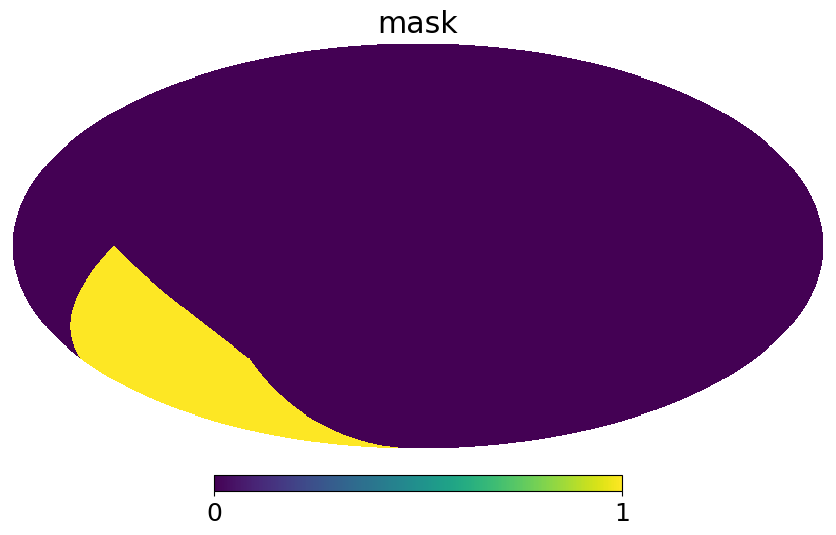

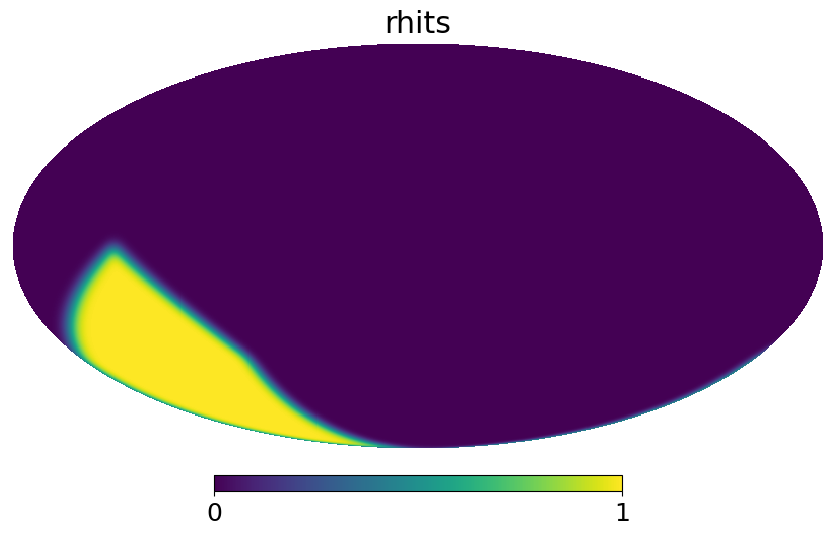

In [6]:
m = np.zeros(hp.nside2npix(1))
m[[9]] = 1
rhits = np.abs(hp.smoothing(hp.ud_grade(m, nside_out=2048),0.1))
mask = hp.ud_grade(m, nside_out=2048)
hp.mollview(mask, title='mask')
hp.mollview(rhits, title='rhits')
print('fsky: {:.3f}'.format(np.mean(m)))

mask_fn = opj(os.environ['SCRATCH'], 'delensalot/generic/sims_cmb_len_lminB200_mfda_maskedsky/mask.fits')
rhits_fn = opj(os.environ['SCRATCH'], 'delensalot/generic/sims_cmb_len_lminB200_mfda_maskedsky/rhits.fits')
if not os.path.isdir(os.path.dirname(mask_fn)):
    os.makedirs(os.path.dirname(mask_fn))
if not os.path.isfile(mask_fn):
    hp.write_map(mask_fn, mask)
    hp.write_map(rhits_fn, rhits)
    print('mask and rhits stored at {}'.format(os.path.dirname(mask_fn)))

# QE lensing reconstruction
The following cell,
 
 * line 1: selects the configuration file,
 * line 2: initialises delensalot for a QE lensing reconstruction job (`job_id`),
 * line 3: perfroms lensing reconstruction and calculates both, the lensing potential, and the $B$-lensing template.

`.run()` also generates CMB simulations and stores them at `DLENSALOT_data.class_parameters.lib_dir`. If this path is not convenient, please choose one that works for you.

This cell will take a while as it also calculates the QE mean-field (and is calculated from $5$ simulations in this tutorial). This is needed, as the masking of the data induces a strong bias in the low-$L$ lensing potential.
For QE, once the mean-field is calculated, it is subtracted from the QE lensing potential estimate to remove this bias.
This QE estimate is later used as a starting point for iterative lensing reconstruction.

This cell takes ~10 min * N (QE estimates to calculate mean-field) + ~30 sec * 20 N (generation of simulation data), and N is the number of simulations

In [2]:
fn = opj(os.getcwd(), 'conf_mwe_maskedsky.py')
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True)
ana_mwe.run()
ana_mwe = ana_mwe.job

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 16:00:32


## Check QE results

`get_plm` and `get_meanfield_normalized` returns the normalized lensing potential and mean-field.
Let us plot it to see if they look as expected

In [2]:
ll = np.arange(0,ana_mwe.lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)
mask = hp.read_map(ana_mwe.mask_fn)

# mf_QE = ana_mwe.get_meanfield_normalized(0)
plm_QE = ana_mwe.get_plm(0, [0])

NameError: name 'ana_mwe' is not defined

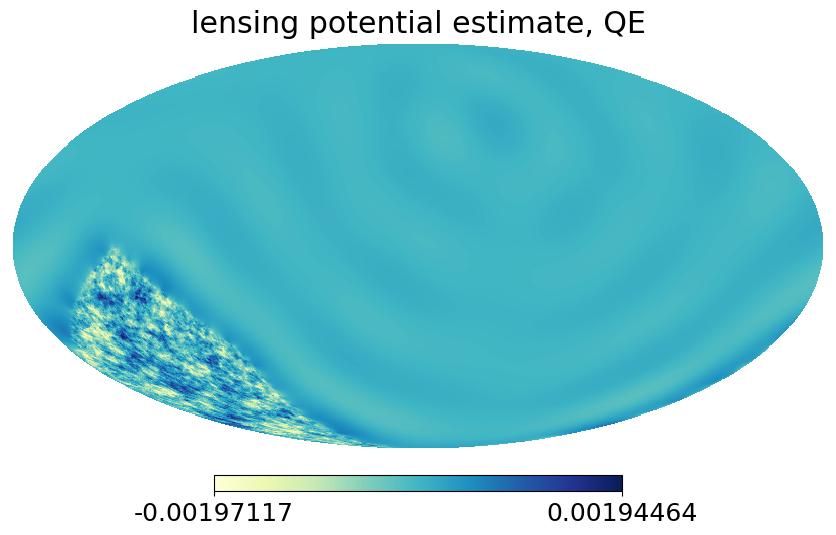

In [4]:
# hp.mollview(hp.alm2map(scale_and_bandpass(mf_QE), nside=1024), title='mean-field, QE', cmap='YlGnBu')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_QE), nside=1024), title='lensing potential estimate, QE', cmap='YlGnBu')
# hp.mollview(mask*hp.alm2map(scale_and_bandpass(plm_QE_fid), nside=2048), cmap='YlGnBu', title='fiducial lensing potential')

In [8]:
plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(scale_factor*hp.alm2cl(plm_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')

plt.plot(scale_factor*hp.alm2cl(mf_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm MF}\hat{\phi}^{\rm MF}}$')

plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,1e-6)
plt.yscale('log')

NameError: name 'scale_factor' is not defined

# iterative lensing reconstruction

The following cell repeats above, but for the iterative case. The settings can be chosen in the configuration file.

In [2]:
ana_mwe = run(config=fn, job_id='MAP_lensrec', verbose=True)
ana_mwe.run()
ana_mwe = ana_mwe.job

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

INFO:: 05-17 18:25:: delensalot.lerepi.core.handler.log - load_configfile() Started: /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/notebooks/examples/conf_mwe_maskedsky.py
INFO:: 05-17 18:25:: delensalot.lerepi.core.metamodel.dlensalot_mm.__attrs_post_init__ - Setting default, using P_FS_CMBS4:
	{'meta': {'version': '0.2'}, 'job': {'jobs': ['generate_sim', 'QE_lensrec', 'MAP_lensrec']}, 'data': {'beam': 1.0, 'nlev_t': 1.0, 'nlev_p': 1.0, 'epsilon': 1e-05, 'nside': 2048, 'class_parameters': {'lmax': 4096, 'cls_unl': {'tt': array([0.00000000e+00, 3.15384486e+03, 1.08426834e+03, ...,
       9.66229400e-10, 9.65260803e-10, 9.64292720e-10]), 'ee': array([0.00000000e+00, 0.00000000e+00, 3.62414129e-02, ...,
       2.00006407e-12, 1.99423451e-12, 1.98828000e-12]), 'bb': array([0., 0., 0., ..., 0., 0., 0.]), 'te': array([0.00000000e+00, 0.00000000e+00, 2.93875049e+00, ...,
       1.40842175e-11, 1.40724986e-11, 1.40607859e-11]), 'pp': array([0.00000000e+00, 5.94954817e-08, 8.92404

# Check your results
## lensing potential and mean-field
After completion of above cells, we can look at the reconstructed lensing potential.
`get_plm_it(idx, its)` returns the spherical harmonics of the lensing potential estimate for simulation `idx` and iteration `its`

In [6]:
ll = np.arange(0,ana_mwe.lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)
mask = hp.read_map(ana_mwe.mask_fn)
fsky = np.mean(mask)

INFO:: 05-17 13:28:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0]) started
INFO:: 05-17 13:28:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0]) finished
INFO:: 05-17 13:28:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0 1 2 3 4]) started
INFO:: 05-17 13:28:: delensalot.core.handler.log - get_plm_it(simidx=0, its=[0 1 2 3 4]) finished
Loaded 5 iterations


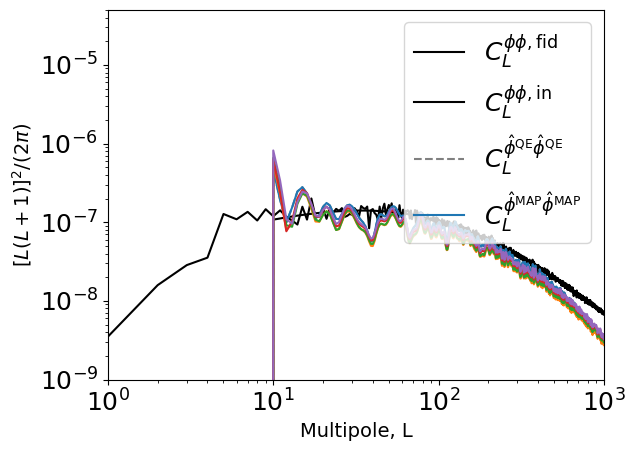

In [23]:
from delensalot.utils_hp import alm_copy
plm_QE = ana_mwe.get_plm_it(0, [0])[0]
plm_MAP = ana_mwe.get_plm_it(0, np.arange(ana_mwe.itmax))
plm_in = alm_copy(ana_mwe._sims.get_sim_plm(0), ana_mwe._sims.lmax+ana_mwe._sims.dlmax, *ana_mwe.lm_max_qlm)

print('Loaded {} iterations'.format(len(plm_MAP)))

plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$', color='black')
plt.plot(scale_factor*hp.alm2cl(plm_in), label=r'$C_L^{\phi\phi,{\rm in}}$', color='black')
plt.plot(scale_factor*hp.alm2cl(plm_QE)/fsky, label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$', color='grey', ls='--')
for n in range(0, len(plm_MAP)):
    label = r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$' if n == 0 else None
    plt.plot(scale_factor*hp.alm2cl(plm_MAP[n])/fsky, label=label)
    # plt.plot(scale_factor*hp.alm2cl(plm_mf)/fsky, label=label, color='black')

plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,5e-5)
plt.yscale('log')

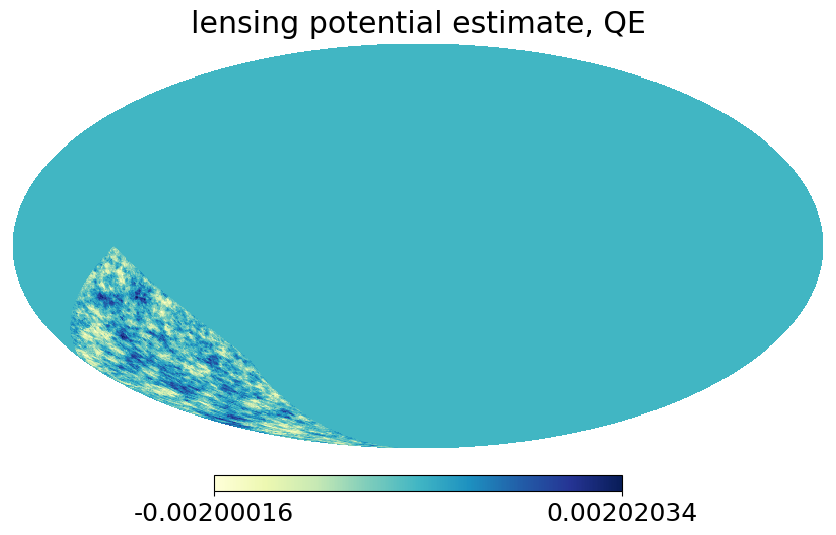

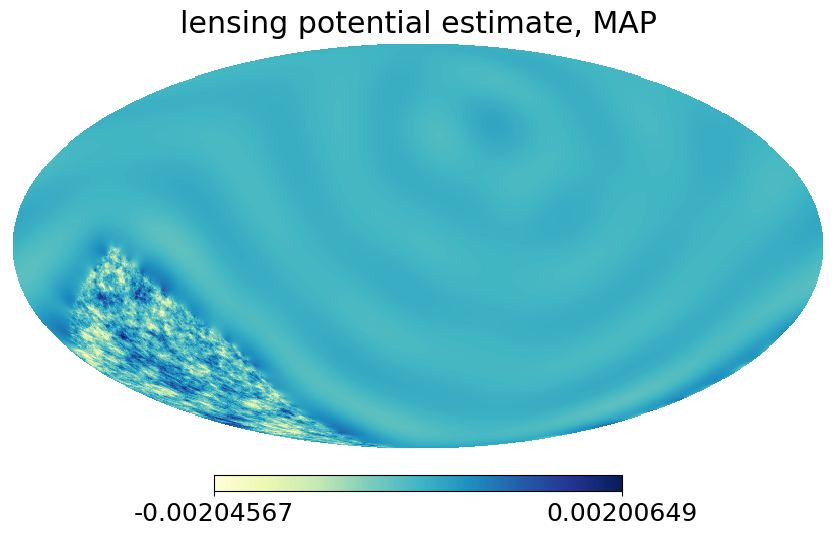

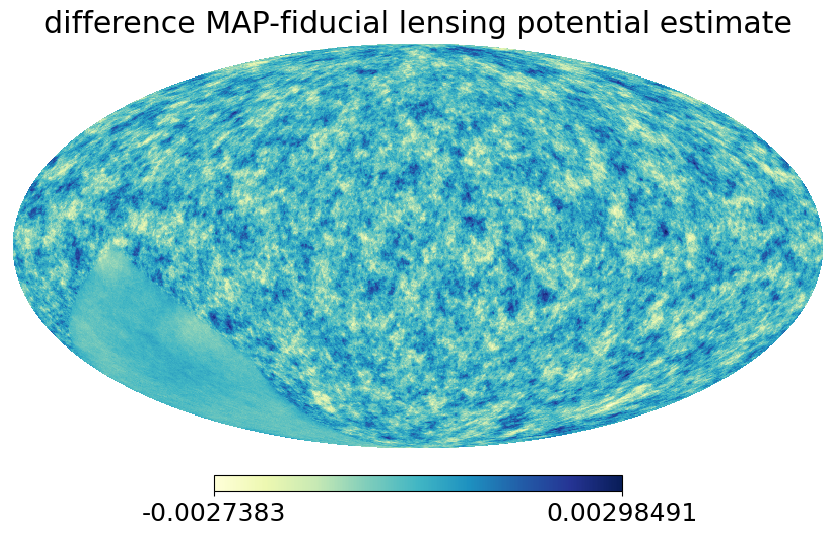

In [26]:
# mask_degrade = hp.ud_grade(mask, nside_out=512)
hp.mollview(hp.alm2map(scale_and_bandpass(plm_QE), nside=512)*mask_degrade, cmap='YlGnBu', title='lensing potential estimate, QE')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_MAP[-1]), nside=512), cmap='YlGnBu', title='lensing potential estimate, MAP')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_MAP[-1]-plm_in), nside=512), cmap='YlGnBu', title='difference MAP-fiducial lensing potential estimate')

# Delensed spectrum
For both QE and iterative lensing reconstruction, delensalot already calculated the B-lensing templates. You can use them to delens the B-lensing maps and obtain residual maps

In [27]:
ana_mwe = run(config=fn, job_id='delens', verbose=True)
ana_mwe.run()
ana_mwe = ana_mwe.job

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

INFO:: 05-17 15:38:: delensalot.lerepi.core.handler.log - load_configfile() Started: /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/notebooks/examples/conf_mwe_maskedsky.py
INFO:: 05-17 15:38:: delensalot.lerepi.core.metamodel.dlensalot_mm.__attrs_post_init__ - Setting default, using P_FS_CMBS4:
	{'meta': {'version': '0.2'}, 'job': {'jobs': ['generate_sim', 'QE_lensrec', 'MAP_lensrec']}, 'data': {'beam': 1.0, 'nlev_t': 1.0, 'nlev_p': 1.0, 'epsilon': 1e-05, 'nside': 2048, 'class_parameters': {'lmax': 4096, 'cls_unl': {'tt': array([0.00000000e+00, 3.15384486e+03, 1.08426834e+03, ...,
       9.66229400e-10, 9.65260803e-10, 9.64292720e-10]), 'ee': array([0.00000000e+00, 0.00000000e+00, 3.62414129e-02, ...,
       2.00006407e-12, 1.99423451e-12, 1.98828000e-12]), 'bb': array([0., 0., 0., ..., 0., 0., 0.]), 'te': array([0.00000000e+00, 0.00000000e+00, 2.93875049e+00, ...,
       1.40842175e-11, 1.40724986e-11, 1.40607859e-11]), 'pp': array([0.00000000e+00, 5.94954817e-08, 8.92404

Traceback (most recent call last):
  File "/home/belkner/anaconda3/envs/delensalot/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3891/375007162.py", line 1, in <module>
    ana_mwe = run(config=fn, job_id='delens', verbose=True)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/delensalot/run.py", line 55, in __init__
    self.model = self._build_model()
                 ^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/delensalot/run.py", line 70, in _build_model
    self.model = self.lerepi_handler.build_model(self.lerepi_handler.jobs[0][self.job_id])
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/belkner/anaconda3/envs/delensalot/lib/python3.11/site-packages/logdecorator/decorator.py", line 19, in 

In [ ]:
input_blensing = hp.map2alm(hp.alm2map(ana_mwe._sims.get_sim_blm(0), nside=2048), lmax=1024)
blt_MAP = ana_mwe.get_blt_it(0, 12)

In [8]:
ana_mwe_QE = run(config=fn, job_id='QE_lensrec', verbose=False).job
blt_QE = ana_mwe_QE.get_blt(0)

In [10]:
blens_residual_QE = input_blensing - blt_QE
blens_residual_MAP = input_blensing - blt_MAP

Text(0, 0.5, '$C_\\ell [\\mu $$\\rm{K}^2$]')

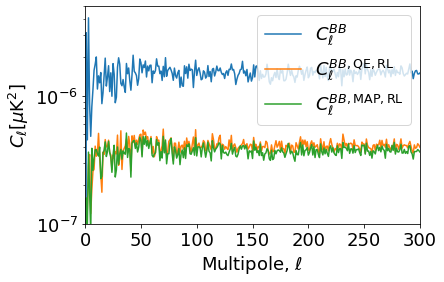

In [17]:
plt.plot(hp.alm2cl(input_blensing, lmax=300), label=r'$C_\ell^{BB}$')
plt.plot(hp.alm2cl(blens_residual_QE, lmax=300)*np.mean(mask), label=r'$C_\ell^{BB,{\rm QE,RL}}$')
plt.plot(hp.alm2cl(blens_residual_MAP, lmax=300)*np.mean(mask), label=r'$C_\ell^{BB,{\rm MAP,RL}}$')

plt.legend()
plt.yscale('log')
plt.xlim(0,300)
plt.ylim(1e-7,5e-6)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')

## residual lensing amplitude $A_{\rm lens}$
A simple estimate of the reduction of lensing power is to take the ratio between the input and resdiual B-lensing signal, averaged across the scales of interest. Here, we simply take the scales about the recombination peak

In [ ]:
print(20*'~.')
print('A_{lens}^{QE}:'+'\t{:.3f}'.format(np.mean((hp.alm2cl(blens_residual_QE, lmax=200)/hp.alm2cl(input_blensing, lmax=200))[30:200])))
print('A_{lens}^{MAP}:'+'\t{:.3f}'.format(np.mean((hp.alm2cl(blens_residual_MAP, lmax=200)/hp.alm2cl(input_blensing, lmax=200))[30:200])))
print(20*'~.')

# Summary and next steps
This tutorial demonstrated the usage of delensalot on a masked sky, and you obtained lensing potential estimates and residual lensing amplitudes from simulation data generated upon runtime.

delensalot can also perfrom lensing reconstruction on more challenging settings such as,

 * inhomogeneous noise,
 * data inclusive of foreground (residuals).
 
Further, it can calculate reconstruction noise `N0`, and `N1`, and make analytical predictions for the delensed power spectra.
It also has MPI support.
 
Please check out the other tutorials, or see the [documentation](link_to_rtd_doc), or [github](https://github.com/NextGenCMB/delensalot) for more.